# Project 2 | ML | 2021-22
- João Santos, 76912
- João Carvalho, 106310

## Pneumonia Dataset
https://www.kaggle.com/datasets/artyomkolas/3-kinds-of-pneumonia

### Imports

In [81]:
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model

import tensorflow_addons as tfa

2.9.1


### Setup Globals

In [82]:
# Check: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

# MODEL = "CNN"
MODEL = "EfficientNet" 
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB0
model_name = "cnn" if MODEL == "CNN" else efficientnet_model.__name__

BATCH_SIZE = 2
EPOCHS = 30

if model_name == 'EfficientNetB0':
    IM_SIZE_W = 224 
    IM_SIZE_H = 224 
elif model_name == 'EfficientNetB1':
    IM_SIZE_W = 240
    IM_SIZE_H = 240
elif model_name == 'EfficientNetB2':
    IM_SIZE_W = 260
    IM_SIZE_H = 260
elif model_name == 'EfficientNetB3':
    IM_SIZE_W = 300
    IM_SIZE_H = 300
elif model_name == 'EfficientNetB4':
    IM_SIZE_W = 380
    IM_SIZE_H = 380
elif model_name == 'EfficientNetB5':
    IM_SIZE_W = 456
    IM_SIZE_H = 456
elif model_name == 'EfficientNetB6':
    IM_SIZE_W = 528
    IM_SIZE_H = 528
elif model_name == 'EfficientNetB7':
    IM_SIZE_W = 600
    IM_SIZE_H = 600
else:
    IM_SIZE_W = 240
    IM_SIZE_H = 240

IM_SIZE_CH = 1 if MODEL == "CNN" else 3

AUTOTUNE = tf.data.experimental.AUTOTUNE

MODEL_PATH = f'./{model_name}'
TRAIN = False

### Load images do Pandas DataFrame

In [83]:
filenames = tf.io.gfile.glob('./Curated X-Ray Dataset/*/*')

data = pd.DataFrame()
for el in range(0, len(filenames)):
    target = filenames[el].split('/')[-2]
    path = filenames[el]
    
    data.loc[el, 'filename'] = path
    data.loc[el, 'class'] = target

print(data['class'].value_counts(dropna=False))
data

Normal                 3270
Pneumonia-Bacterial    3001
Pneumonia-Viral        1656
COVID-19               1281
Name: class, dtype: int64


,filename,class
0,./Curated X-Ray Dataset/COVID-19/COVID-19 (109...,COVID-19
1,./Curated X-Ray Dataset/COVID-19/COVID-19 (118...,COVID-19
2,./Curated X-Ray Dataset/COVID-19/COVID-19 (244...,COVID-19
3,./Curated X-Ray Dataset/COVID-19/COVID-19 (521...,COVID-19
4,./Curated X-Ray Dataset/COVID-19/COVID-19 (135...,COVID-19
...,...,...
9203,./Curated X-Ray Dataset/Normal/Normal (3139).jpg,Normal
9204,./Curated X-Ray Dataset/Normal/Normal (1542).jpg,Normal
9205,./Curated X-Ray Dataset/Normal/Normal (245).jpg,Normal
9206,./Curated X-Ray Dataset/Normal/Normal (173).jpg,Normal


### Shuffle data and make class numerical

In [84]:
data = shuffle(data)
data.reset_index(drop=True, inplace=True)

change = {
'Normal' : '0',
'Pneumonia-Bacterial': '1',
'Pneumonia-Viral' : '2',
'COVID-19' : '3',
}

data['class'] = data['class'].map(change)
data

,filename,class
0,./Curated X-Ray Dataset/COVID-19/COVID-19 (109...,3
1,./Curated X-Ray Dataset/Normal/Normal (287).jpg,0
2,./Curated X-Ray Dataset/Pneumonia-Viral/Pneumo...,2
3,./Curated X-Ray Dataset/Normal/Normal (2003).jpg,0
4,./Curated X-Ray Dataset/Pneumonia-Bacterial/Pn...,1
...,...,...
9203,./Curated X-Ray Dataset/COVID-19/COVID-19 (918...,3
9204,./Curated X-Ray Dataset/Normal/Normal (1810).jpg,0
9205,./Curated X-Ray Dataset/COVID-19/COVID-19 (109...,3
9206,./Curated X-Ray Dataset/Pneumonia-Viral/Pneumo...,2


### Split data

In [85]:
# Split data into train and validation
train_data, val_data = train_test_split(data, test_size=0.1, stratify=data['class'])
print(train_data['class'].value_counts(dropna=False))
print(val_data['class'].value_counts(dropna=False))

# Split train into train and test
train_data, test_data = train_test_split(train_data, test_size=0.1, stratify=train_data['class'])
print(train_data['class'].value_counts(dropna=False))
print(test_data['class'].value_counts(dropna=False))

0    2943
1    2701
2    1490
3    1153
Name: class, dtype: int64
0    327
1    300
2    166
3    128
Name: class, dtype: int64
0    2648
1    2431
2    1341
3    1038
Name: class, dtype: int64
0    295
1    270
2    149
3    115
Name: class, dtype: int64


### Define ImageDataGenerator

In [86]:
color_mode='grayscale' if MODEL == "CNN" else 'rgb'
scale = 1./255 if MODEL == "CNN" else None

datagen = ImageDataGenerator(rescale = scale,
                            zoom_range= 0.05,
                            brightness_range=[0.9, 1.0],
                            height_shift_range=0.05, 
                            width_shift_range=0.05,
                            rotation_range=10, 
                            )

test_datagen = ImageDataGenerator(rescale = scale)

train_gen = datagen.flow_from_dataframe(train_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode=color_mode,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True,
                                        num_parallel_calls=AUTOTUNE)

val_gen = test_datagen.flow_from_dataframe(val_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode=color_mode,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

test_gen = test_datagen.flow_from_dataframe(test_data,
                                        x_col="filename",
                                        y_col="class",
                                        target_size=(IM_SIZE_W, IM_SIZE_H),
                                        color_mode=color_mode,
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False,
                                        num_parallel_calls=AUTOTUNE)

Found 7458 validated image filenames belonging to 4 classes.
Found 921 validated image filenames belonging to 4 classes.
Found 829 validated image filenames belonging to 4 classes.


### CNN Model

In [87]:
def create_model_CNN():
    
    # Model input
    input_layer = layers.Input(shape=(IM_SIZE_W, IM_SIZE_H, IM_SIZE_CH), name='input')  

    # First block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_1')(input_layer)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
    x = layers.Dropout(0.1, name='dropout_1')(x)

    # Second block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)

    # Third block
    x = layers.Conv2D(filters=128, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_3')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)

    # Fourth block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_4')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
    x = layers.Dropout(0.1, name='dropout_4')(x)

    # Fifth block
    x = layers.Conv2D(filters=256, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_5')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
    x = layers.Dropout(0.1, name='dropout_5')(x)

    # Sixth block
    x = layers.Conv2D(filters=512, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_6')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_6')(x)
    x = layers.Dropout(0.1, name='dropout_6')(x)

    # Seventh block
    x = layers.Conv2D(filters=512, kernel_size=3, 
                        activation='relu', padding='same', 
                        name='conv2d_7')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_7')(x)
    x = layers.Dropout(0.1, name='dropout_7')(x)
    
    # GlobalAveragePooling
    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)   
    x = layers.Flatten()(x)
    
    # Head
    x = layers.Dense(1024,activation='relu')(x)
    x = layers.Dropout(0.1, name='dropout_head_2')(x)
    x = layers.Dense(128,activation='relu')(x)
    
    # Output
    output = layers.Dense(units=4, 
                            activation='softmax', 
                            name='output')(x)


    model = Model(input_layer, output)
        
    F_1_macro = tfa.metrics.f_scores.F1Score(num_classes=4, average="macro", name='f1_macro') 
    
    model.compile(optimizer='adam', 
                    loss='categorical_crossentropy', 
                    metrics=F_1_macro)

    return model

### EfficientNet Model

In [88]:
def create_model_B3(base_trainable = True):
    img_shape = (IM_SIZE_W, IM_SIZE_H, IM_SIZE_CH)

    base_model=efficientnet_model(include_top=False,
        weights="imagenet",
        input_shape=img_shape, 
        pooling='max') 

    base_model.trainable=base_trainable

    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)

    x=Dropout(rate=.4)(x)       
    output=Dense(4, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)

    lr=.001 # start with this learning rate
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

    return model

### Create Model

In [89]:
if TRAIN:
    model = create_model_CNN() if MODEL == "CNN" else create_model_B3(False)
else:
    model = load_model(MODEL_PATH)

model.summary()

# plot_model(model, 
#     to_file='model_plot.png', 
#     show_shapes=True, 
#     show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

### Train the model

In [90]:
if TRAIN:
    init_time = datetime.datetime.now()


    train_steps = train_gen.samples // BATCH_SIZE
    valid_steps = val_gen.samples // BATCH_SIZE

    early_stopping = EarlyStopping(monitor="val_loss", patience=4, mode="min", min_delta=0.01)

    learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, 
                                                min_lr=1e-7, verbose=1, mode="min")

    checkpoint = ModelCheckpoint("loss-{val_loss:.4f}.h5", monitor="val_loss", verbose=0, 
                                save_best_only=True, save_weights_only=True, mode="min")

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=[
                    checkpoint, 
                    early_stopping, 
                    learning_rate_reduction],
        verbose=1,
        )

    required_time = datetime.datetime.now() - init_time
    print(f'\nRequired time:  {str(required_time)}\n')   

### Plots

In [91]:
if TRAIN:
    history_df = pd.DataFrame(history.history)
else:
    history_df = pd.read_csv(MODEL_PATH+'/history.csv')

print(history_df.keys())

Index(['Unnamed: 0', 'loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'], dtype='object')


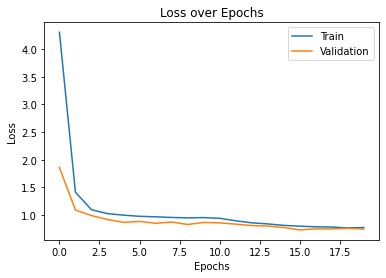

In [92]:
history_df.loc[0:, ['loss', 'val_loss']].plot(
    title='Loss over Epochs',
    xlabel='Epochs',
    ylabel='Loss')
plt.legend(["Train", "Validation"])
plt.savefig(f'./imgs/{model_name}_loss.pdf', format='pdf', bbox_inches='tight')

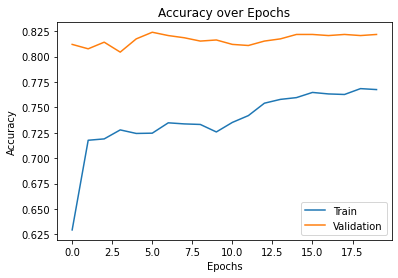

In [93]:
history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(
    title='Accuracy over Epochs',
    xlabel='Epochs',
    ylabel='Accuracy')
plt.legend(["Train", "Validation"])
plt.savefig(f'./imgs/{model_name}_accu.pdf', format='pdf', bbox_inches='tight')

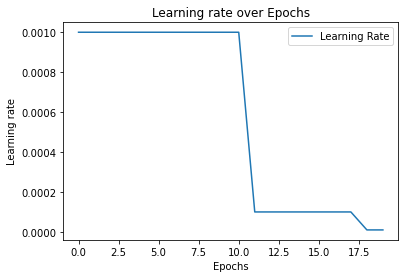

In [94]:
history_df.loc[0:, ['lr']].plot(
    title='Learning rate over Epochs',
    xlabel='Epochs',
    ylabel='Learning rate')
plt.legend(["Learning Rate"])
plt.savefig(f'./imgs/{model_name}_lr.pdf', format='pdf', bbox_inches='tight')

### Test the model

In [95]:
test_steps = test_gen.samples // BATCH_SIZE

test_loss, test_acc = model.evaluate(test_gen, steps=test_steps)
print('\naccuracy:', test_acc, 'loss: ',test_loss)

414/414 [==============================] - 98s 224ms/step - loss: 0.7458 - accuracy: 0.8128

accuracy: 0.8128019571304321 loss:  0.7457826137542725


In [96]:
predict = model.predict(test_gen, steps=test_steps)
y_pred = np.argmax(predict, axis=1)

414/414 [==============================] - 93s 216ms/step


In [97]:
test_labels_df = pd.DataFrame()
test_labels_df[['class']] = test_data[['class']]

change = {
'0' : 0,
'1' : 1,
'2' : 2,
'3' : 3,
}

# change = {
# '0': 'Normal',
# '1': 'Pneumonia-Bacterial',
# '2': 'Pneumonia-Viral',
# '3': 'COVID-19',
# }

test_labels_df['class'] = test_labels_df['class'].map(change)
test_labels_df = test_labels_df[ : test_steps*BATCH_SIZE]


y_test = np.array(test_labels_df['class'])
y_test[:20]

array([0, 0, 0, 3, 1, 1, 0, 0, 3, 1, 1, 1, 0, 2, 0, 1, 2, 0, 3, 0])

### Classification Report

In [98]:
report = classification_report(y_test, y_pred)
print(report)

with open(f'./{model_name}_report.txt', 'w') as f:
    f.write(report)

cm = confusion_matrix(y_test, y_pred)

# sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       295
           1       0.76      0.79      0.78       269
           2       0.73      0.38      0.50       149
           3       0.96      0.97      0.97       115

    accuracy                           0.81       828
   macro avg       0.82      0.78      0.78       828
weighted avg       0.80      0.81      0.80       828



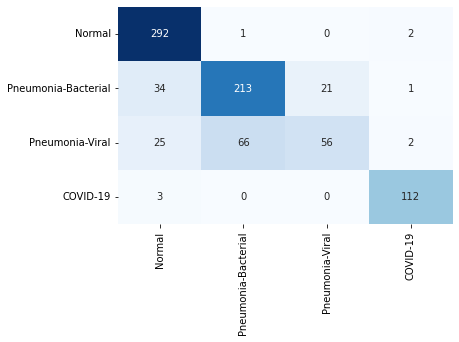

In [99]:
labels = ['Normal','Pneumonia-Bacterial','Pneumonia-Viral','COVID-19']
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False, xticklabels=labels, yticklabels=labels)
plt.savefig(f'./imgs/{model_name}_confusion.pdf', format='pdf', bbox_inches='tight')

### Save the model

In [100]:
if TRAIN:
    path = MODEL_PATH + '/'
    if (not os.path.exists(path)):
        os.mkdir(path)
        
    model.save(path)
    history_df.to_csv(path+'history.csv')